<a href="https://colab.research.google.com/github/WoradeeKongthong/image_classification/blob/master/Fashion_MNIST_image_classification_KfoldCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
import numpy as np

# Dataset

## Load the Fashion-MNIST dataset
Labels  

Each training and test example is assigned to one of the following labels:

0 T-shirt/top  
1 Trouser  
2 Pullover  
3 Dress  
4 Coat  
5 Sandal  
6 Shirt  
7 Sneaker  
8 Bag  
9 Ankle boot  

In [2]:
# load dataset
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

Train X shape :  (60000, 28, 28)
Train y shape :  (60000,)
Test X shape :  (10000, 28, 28)
Test y shape :  (10000,)


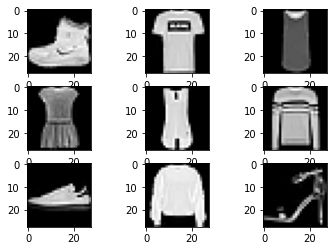

In [3]:
# summarize loaded dataset
print('Train X shape : ', trainX.shape)
print('Train y shape : ', trainy.shape)
print('Test X shape : ', testX.shape)
print('Test y shape : ', testy.shape)

# plot some images
for i in range(9):
  plt.subplot(330 + i + 1)
  plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
plt.show()

## Preprocess dataset

In [4]:
# reshape trainX and testX to have single channel
trainX = np.expand_dims(trainX, axis=3)
testX = np.expand_dims(testX, axis=3)

print('Train X shape : ', trainX.shape)
print('Test X shape : ', testX.shape)

Train X shape :  (60000, 28, 28, 1)
Test X shape :  (10000, 28, 28, 1)


In [5]:
print(trainy[:10])

[9 0 0 3 0 2 7 2 5 5]


In [6]:
# one hot encode trainy and testy 
#(keras.utils.to_categorical converts a class vector (integers) to binary class matrix)

trainy = to_categorical(trainy)
testy = to_categorical(testy)

print('Train y shape : ', trainy.shape)
print('Test y shape : ', testy.shape)
print('Train y examples :')
for i in range(9):
  print(trainy[i])

Train y shape :  (60000, 10)
Test y shape :  (10000, 10)
Train y examples :
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [7]:
# check Pixel Data
print(trainX.dtype)
print('min : %d, max : %d' %(trainX.min(), trainX.max()))

uint8
min : 0, max : 255


In [8]:
# convert from uint8 to float32
trainX = trainX.astype('float32')
testX = testX.astype('float32')

# normalize to range 0-1
trainX = trainX / 255.0
testX = testX / 255.0

# check Pixel Data
print(trainX.dtype)
print('min : %d, max : %d' %(trainX.min(), trainX.max()))

float32
min : 0, max : 1


# Baseline Model

## Define Model

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD

In [ ]:
# define simple CNN model
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(28,28,1)))
  model.add(MaxPooling2D((2,2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  # compile model
  opt = SGD(lr=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

## Evaluate Mode (K-fold cross validation)

In [ ]:
from sklearn.model_selection import KFold

def evaluate_model(trainX, trainy, testX, testy, n_folds=5):
  scores = list()
  histories = list()

  # create k-fold corss validator
  kfold = KFold(n_splits=n_folds, shuffle=True)

  # enumerate the splits (5 splits or folds in total)
  for train_index, val_index in kfold.split(trainX):
    
    # select training and validation sets
    train_X, train_y, val_X, val_y = trainX[train_index], trainy[train_index], trainX[val_index], trainy[val_index]
    
    # define model
    model = define_model()

    # fit the model
    history = model.fit(train_X, train_y, epochs=5, batch_size=32, verbose=0, validation_data=(val_X, val_y))

    # evaluate model on test set
    _, acc = model.evaluate(testX, testy, verbose=0)
    print('>accuracy : %.3f' %(acc * 100.0))

    # append scores and histories
    scores.append(acc)
    histories.append(history)
  return scores, histories

In [ ]:
scores, histories = evaluate_model(trainX, trainy, testX, testy, n_folds=5)

>accuracy : 89.830
>accuracy : 90.570
>accuracy : 90.520
>accuracy : 89.580
>accuracy : 89.590


## Results

In [ ]:
# plot learning curve and print model performance
def summarize_model(scores, histories):
  # learning curve
  plt.figure(figsize=(8,8))
  for i in range(len(histories)):
    # plot loss
    plt.subplot(211)
    plt.plot(histories[i].history['loss'], color='green', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='validation')
    plt.title('Cross Entropy Loss')

    # plot accuracy
    plt.subplot(212)
    plt.plot(histories[i].history['accuracy'], color='green', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='validation')
    plt.title('Classification Accuracy')
  plt.show()
  # model performance
  print('Accuracy : mean = %.3f, std = %.3f, n = %d' %(np.mean(scores)*100.0, np.std(scores)*100.0, len(scores)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


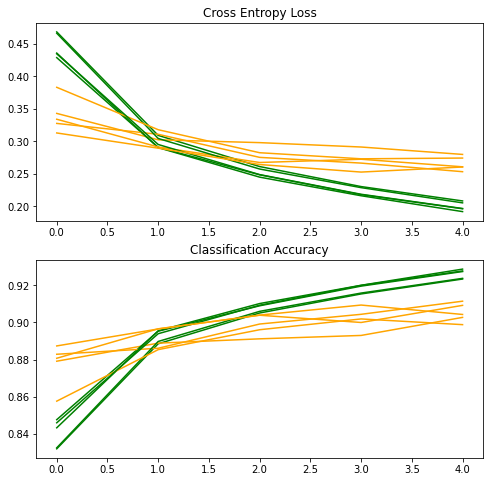

Accuracy : mean = 90.018, std = 0.440, n = 5


In [ ]:
summarize_model(scores, histories)

# Develop Model : add padding (to improve performance)

In [ ]:
# define the model
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(28,28,1)))
  model.add(MaxPooling2D((2,2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  # compile model
  opt = SGD(lr=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

>accuracy : 90.490
>accuracy : 89.300
>accuracy : 90.160
>accuracy : 89.970
>accuracy : 90.560


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


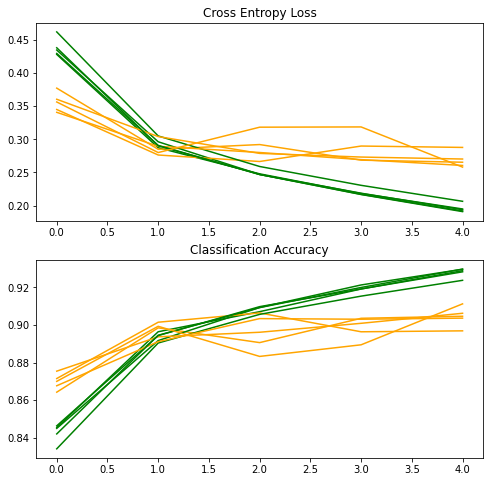

Accuracy : mean = 90.096, std = 0.453, n = 5


In [ ]:
# evaluate the model and print performance
scores, histories = evaluate_model(trainX, trainy, testX, testy, n_folds=5)
summarize_model(scores, histories)

Note : the performance increase a little

# Develop Model : increasing filters (to imporve performance)

In [ ]:
# define the model
def define_model():
  model = Sequential()
  model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(28,28,1)))
  model.add(MaxPooling2D((2,2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  # compile model
  opt = SGD(lr=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

>accuracy : 90.130
>accuracy : 89.830
>accuracy : 90.110
>accuracy : 89.380
>accuracy : 89.140


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


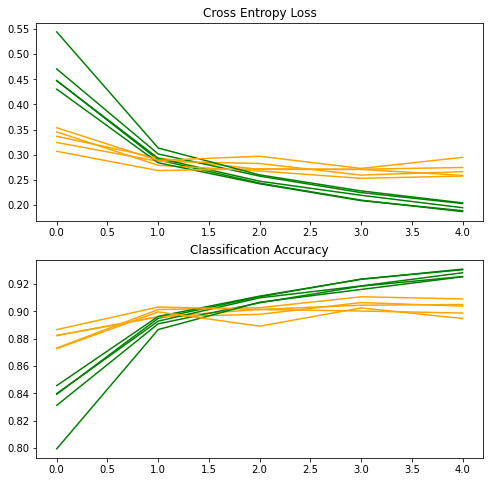

Accuracy : mean = 89.718, std = 0.396, n = 5


In [ ]:
# evaluate the model and print performance
scores, histories = evaluate_model(trainX, trainy, testX, testy, n_folds=5)
summarize_model(scores, histories)

Note : to develop model further  
to reduce overfitting
*   add regularization (Dropout layer)
*   training for fewer epochs
*   data augmentation


to improve performance
*   model depth
*   learning rate


# Finalize the model and Save it
Finalize the model : fit the model with entire training set  
Save the model as .h5 

In [ ]:
# Finalize Model
model.fit(trainX, trainy, epochs=5, batch_size=32, verbose=1)
# Save the Model
model.save('final_model.h5')

Epoch 1/5
1875/1875 [==============================] - 33s 18ms/step - loss: 0.1981 - accuracy: 0.9271
Epoch 2/5
1875/1875 [==============================] - 33s 18ms/step - loss: 0.1777 - accuracy: 0.9352
Epoch 3/5
1875/1875 [==============================] - 33s 18ms/step - loss: 0.1601 - accuracy: 0.9412
Epoch 4/5
1875/1875 [==============================] - 33s 17ms/step - loss: 0.1453 - accuracy: 0.9469
Epoch 5/5
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1312 - accuracy: 0.9522


# Prediction
Make a prediction on a single image with the saved final model

In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


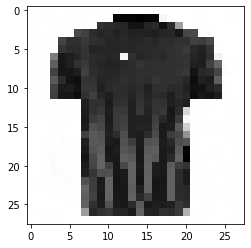

prediction :  2


In [ ]:
# load image
img = load_img('tshirt.png', grayscale=True, target_size=(28,28))
# plot image
plt.imshow(img, cmap='Greys_r')
plt.show()
# convert image to array
img = img_to_array(img)
# reshape image to single sample with 1 channel
img = img.reshape(1,28,28,1)
# normalize the pixel data
img = img.astype('float32')
img = img / 255.0

# load model
model = load_model('final_model.h5')

# make prediction
result = model.predict_classes(img)
print('prediction : ', result[0])

Note : predicted label (2) is a pullover  
but the ground truth is a t-shirt (0)